In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('wordnet_ic')
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import random
from nltk import pos_tag
from nltk.wsd import lesk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
data=pd.read_csv('/content/Data_train (80).csv')
data

,statement,status
0,i ve thought of ending my life so many time bu...,Depression
1,there is nothing to look forward to just the s...,Depression
2,just realized im talking to no one,Normal
3,husband stayed home from work today again hes ...,Bipolar
4,it feels like i am being punished for having i...,Depression
...,...,...
14916,tw suicide if i never kill myself all of this ...,Bipolar
14917,i find myself extremely less productive these ...,Depression
14918,what s the best way to eat reheated pizza i ke...,Normal
14919,its am seroquel reduction is going really well...,Bipolar


In [ ]:
data['status'].value_counts()

,count
status,
Normal,4904
Depression,4469
Anxiety,2164
Bipolar,1457
Stress,1401
Personality disorder,526


In [ ]:
data['word_count'] = data['statement'].apply(lambda x: len(str(x).split()))
max_word_count_train = data['word_count'].max()
print("Max Word Count in data_train:", max_word_count_train)

Max Word Count in data_train: 444


In [ ]:
min_word_count_train = data['word_count'].min()
print("Min Word Count in data_train:", min_word_count_train)

Min Word Count in data_train: 1


In [ ]:
min_word_count_train = data['word_count'].min()
min_texts = data[data['word_count'] == min_word_count_train]['statement']  # Sesuaikan dengan nama kolom teks

print("Teks dengan jumlah kata paling sedikit:")
for text in min_texts:
    print(text)

Teks dengan jumlah kata paling sedikit:
jibeom
anxious
sbsmtv
teleport


In [ ]:
data = data[data['word_count'] > 1]

In [ ]:
data = data.drop(columns=['word_count'])

In [ ]:
data

,statement,status
0,i ve thought of ending my life so many time bu...,Depression
1,there is nothing to look forward to just the s...,Depression
2,just realized im talking to no one,Normal
3,husband stayed home from work today again hes ...,Bipolar
4,it feels like i am being punished for having i...,Depression
...,...,...
14916,tw suicide if i never kill myself all of this ...,Bipolar
14917,i find myself extremely less productive these ...,Depression
14918,what s the best way to eat reheated pizza i ke...,Normal
14919,its am seroquel reduction is going really well...,Bipolar


In [ ]:
data['status'].value_counts()

,count
status,
Normal,4901
Depression,4469
Anxiety,2163
Bipolar,1457
Stress,1401
Personality disorder,526


## Syntax WORDNET + LESK##

## Depression ##

In [ ]:
from nltk.corpus import wordnet as wn

# Fungsi untuk mendapatkan POS tag yang sesuai dengan WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

# Fungsi untuk mengganti sinonim dalam teks
def synonym_replacement(text):
    words = word_tokenize(text)
    words_pos = pos_tag(words)
    stop_words = set(stopwords.words('english'))
    new_words = words.copy()
    replaced_words = 0

    num_words = len(words)
    if num_words <= 100:
        n = max(1, int(0.1 * num_words))  # 10% dari total kata, minimal 1 kata
    else:
        n = 10  # Maksimal 10 kata jika lebih dari 100 kata

    # Ambil kandidat untuk diganti (bukan stopword, angka, atau simbol)
    candidates = [i for i, (word, pos) in enumerate(words_pos)
                  if word.lower() not in stop_words and word.isalpha()]
    random.shuffle(candidates)

    for i in candidates:
        word, pos = words_pos[i]
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos is None:
            continue

        # Identifikasi makna menggunakan Lesk
        sense = lesk(words, word, pos=wordnet_pos)
        if not sense:
            continue

        # Cari sinonim yang sesuai dengan konteks di WordNet
        sense_synonyms = [lemma.name().replace('_', ' ') for lemma in sense.lemmas() if lemma.name().lower() != word.lower()]

        if sense_synonyms:
            selected_synonym = random.choice(sense_synonyms)
            if selected_synonym.lower() != word.lower():
                new_words[i] = selected_synonym
                replaced_words += 1

        if replaced_words == n:
            break

    augmented_text = ' '.join(new_words)
    return augmented_text if augmented_text != text else text

# Proses augmentasi
depression_texts = data[data['status'] == 'Depression']['statement'].sample(432, random_state=42)
augmented_data = []

for text in depression_texts:
    augmented_text = synonym_replacement(text)
    augmented_data.append((text, augmented_text, 'Depression'))

# Buat DataFrame baru
augmented_df = pd.DataFrame(augmented_data, columns=['original_statement', 'statement', 'status'])

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,jayjude imthiyas pv kennylanta ng abdulbasit g...,jayjude imthiyas pv kennylanta ng abdulbasit g...,Depression
1,i have struggled with depression for almost ye...,i have struggled with depression for well-nigh...,Depression
2,six years ago today i divorced my physically a...,six year ago today i divorced my physically an...,Depression
3,lol that is pretty much it they go from being ...,lol that is somewhat much it they go from bein...,Depression
4,so i ve been taking mirtazapine for year for m...,so i ve been take mirtazapine for year for my ...,Depression
...,...,...,...
427,i used to have such quirky tastes i used to lo...,i used to have such quirky taste perception i ...,Depression
428,i have been on the max dose of cymbalta and bu...,i have been on the Georgia home boy dose of cy...,Depression
429,slowly losing my life after covid i am now i h...,slowly lose my lifespan after covid i am now i...,Depression
430,im so tired i just want to sleep forever makin...,im so tired i just want to sleep forever make ...,Depression


In [ ]:
pd.set_option('display.max_colwidth', None)
print(augmented_df.iloc[430])

original_statement    im so tired i just want to sleep forever making a promise to myself that tonight is the night reaching out for help didn t work i can t do this anymore sorry guy
statement                im so tired i just want to sleep forever make a promise to myself that tonight is the night reach out for helper didn t work i can t do this anymore sorry guy
status                                                                                                                                                                       Depression
Name: 430, dtype: object


In [ ]:
import string

# Mengubah teks menjadi lowercase dan menghapus tanda baca
augmented_df['statement'] = augmented_df['statement'].str.lower()  # Ubah menjadi lowercase
augmented_df['statement'] = augmented_df['statement'].str.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,jayjude imthiyas pv kennylanta ng abdulbasit goal overcame depression then why did you choose to have depression in the first place since it wa a choice,jayjude imthiyas pv kennylanta ng abdulbasit goal overcame depressive disorder then why did you choose to have depressive disorder in the first place since it wa a choice,Depression
1,i have struggled with depression for almost years now it feels different it feels stronger it feels darker i can see my reflection in the mirror but i do not know who i am who was i before am i even any different sleep used to be my escape from myself but my dreams are vivid and awful now the anxiety has crept into my unconscious i am alone inside of myself i have been taking lamictal for years and recently i have gone without them for a few weeks due to unfortunate circumstances i know i am experiencing withdrawal from them my mind is foggy and distracted i cannot concentrate on even a television show i enjoy the things that used to soothe me are no longer working every day is the same as the last in my mind i tried to quit smoking cigarettesbut i cannot seem to let go of them my therapist has me confused and scared about what could be wrong with me mentally i have broken up with a very close friend because they accused me of being selfish and toxic maybe i am but i am just trying to survive i do not want to die i just want to be okay i cannot work my finances are being taken care of by my year old mother who works overtime to support me through this i am forever grateful for her sacrifice the shame of not being able to support myself as an adult is weighing heavy on my self worth and esteem i am in a very dark place and i am afraid sometimes i lay in bed and think about all the people in the world and how a lot of them feel lost or scared or just empty like me how can i be on this planet with so many people and feel completely isolated my friends love me my family loves me my boyfriend loves me i know this but it does not cure me i am my own enemy my mind is a prison and i silently scream internally every day how is that for dramatic i cannot find the words to express myself,i have struggled with depression for wellnigh year now it feel different it feels stronger it feels darker i can see my reflection in the mirror but i do not know who i am who was i before am i even any different sleep used to be my escape from myself but my dream are vivid and awful now the anxiety has crept into my unconscious i am alone inside of myself i have been taking lamictal for years and recently i have rifle without them for a few weeks due to unfortunate setting i know i am experiencing coitus interruptus from them my mind is foggy and distracted i can not concentrate on even a television show i enjoy the things that used to soothe me are no longer working every day is the same as the last in my nous i tried to quit smoking cigarettesbut i can not seem to let go of them my therapist has me confused and scared about what could be wrong with me mentally i have broken up with a very close friend because they accused me of being selfish and toxic maybe i am but i am just trying to survive i do not want to die i just want to be okay i can not work my finances are being taken attention of by my year old mother who works overtime to support me through this i am forever grateful for her sacrifice the shame of not being able to support myself as an adult is weighing heavy on my self worth and esteem i am in a very dark place and i am afraid sometimes i lay in bed and think about all the people in the world and how a lot of them feel lost or scared or just empty like me how can i be on this planet with so many people and feel completely isolated my friends love me my family loves me my boyfriend love me i know this but it does not cure me i am my own enemy my mind is a prison and i silently scream internally every day how is that for dramatic i can not find the words to express mysel

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

# Fungsi untuk menghitung BLEU dan SBLEU
def calculate_bleu_scores(original, augmented):
    # Tokenisasi teks asli dan teks augmentasi
    reference = [word_tokenize(original)]
    candidate = word_tokenize(augmented)

    # BLEU score tanpa smoothing
    bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    # SBLEU score dengan smoothing method 1 (Chen and Cherry smoothing method)
    chencherry = SmoothingFunction()
    sbleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),
                                smoothing_function=chencherry.method1)

    return bleu_score, sbleu_score

# List untuk menyimpan nilai BLEU dan SBLEU per baris
bleu_scores = []
sbleu_scores = []

# Hitung BLEU dan SBLEU untuk setiap baris
for index, row in augmented_df.iterrows():
    original_text = row['original_statement']
    augmented_text = row['statement']

    bleu, sbleu = calculate_bleu_scores(original_text, augmented_text)
    bleu_scores.append(bleu)
    sbleu_scores.append(sbleu)

# Tambahkan kolom baru untuk nilai BLEU dan SBLEU di DataFrame
augmented_df['BLEU'] = bleu_scores
augmented_df['SBLEU'] = sbleu_scores

# Hitung rata-rata BLEU dan SBLEU
average_bleu = np.mean(bleu_scores)
average_sbleu = np.mean(sbleu_scores)

# Tampilkan rata-rata BLEU dan SBLEU
print(f"Rata-rata BLEU Score: {average_bleu}")
print(f"Rata-rata SBLEU Score: {average_sbleu}")

Rata-rata BLEU Score: 0.8165975385962001
Rata-rata SBLEU Score: 0.8170733876898351


In [ ]:
augmented_df

,original_statement,statement,status,BLEU,SBLEU
0,jayjude imthiyas pv kennylanta ng abdulbasit goal overcame depression then why did you choose to have depression in the first place since it wa a choice,jayjude imthiyas pv kennylanta ng abdulbasit goal overcame depressive disorder then why did you choose to have depressive disorder in the first place since it wa a choice,Depression,0.725420,0.725420
1,i have struggled with depression for almost years now it feels different it feels stronger it feels darker i can see my reflection in the mirror but i do not know who i am who was i before am i even any different sleep used to be my escape from myself but my dreams are vivid and awful now the anxiety has crept into my unconscious i am alone inside of myself i have been taking lamictal for years and recently i have gone without them for a few weeks due to unfortunate circumstances i know i am experiencing withdrawal from them my mind is foggy and distracted i cannot concentrate on even a television show i enjoy the things that used to soothe me are no longer working every day is the same as the last in my mind i tried to quit smoking cigarettesbut i cannot seem to let go of them my therapist has me confused and scared about what could be wrong with me mentally i have broken up with a very close friend because they accused me of being selfish and toxic maybe i am but i am just trying to survive i do not want to die i just want to be okay i cannot work my finances are being taken care of by my year old mother who works overtime to support me through this i am forever grateful for her sacrifice the shame of not being able to support myself as an adult is weighing heavy on my self worth and esteem i am in a very dark place and i am afraid sometimes i lay in bed and think about all the people in the world and how a lot of them feel lost or scared or just empty like me how can i be on this planet with so many people and feel completely isolated my friends love me my family loves me my boyfriend loves me i know this but it does not cure me i am my own enemy my mind is a prison and i silently scream internally every day how is that for dramatic i cannot find the words to express myself,i have struggled with depression for wellnigh year now it feel different it feels stronger it feels darker i can see my reflection in the mirror but i do not know who i am who was i before am i even any different sleep used to be my escape from myself but my dream are vivid and awful now the anxiety has crept into my unconscious i am alone inside of myself i have been taking lamictal for years and recently i have rifle without them for a few weeks due to unfortunate setting i know i am experiencing coitus interruptus from them my mind is foggy and distracted i can not concentrate on even a television show i enjoy the things that used to soothe me are no longer working every day is the same as the last in my nous i tried to quit smoking cigarettesbut i can not seem to let go of them my therapist has me confused and scared about what could be wrong with me mentally i have broken up with a very close friend because they accused me of being selfish and toxic maybe i am but i am just trying to survive i do not want to die i just want to be okay i can not work my finances are being taken attention of by my year old mother who works overtime to support me through this i am forever grateful for her sacrifice the shame of not being able to support myself as an adult is weighing heavy on my self worth and esteem i am in a very dark place and i am afraid sometimes i lay in bed and think about all the people in the world and how a lot of them feel lost or scared or just empty like me how can i be on this planet with so many people and feel completely isolated my friends love me my family loves me my boyfriend love me i know this but it does not cure me i am my own enemy my mind is a prison and i silently scream internally every day how is that for dramatic i can not fi

In [ ]:
# Simpan ke dalam file CSV
augmented_df.to_csv('SR_wordnet_Depressionfixxbgtsemhas.csv', index=False)

In [ ]:
# Pilih kolom yang diinginkan
augmented_df_filtered = augmented_df[['statement', 'status']]
augmented_df_filtered

,statement,status
0,jayjude imthiyas pv kennylanta ng abdulbasit goal overcame depressive disorder then why did you choose to have depressive disorder in the first place since it wa a choice,Depression
1,i have struggled with depression for wellnigh year now it feel different it feels stronger it feels darker i can see my reflection in the mirror but i do not know who i am who was i before am i even any different sleep used to be my escape from myself but my dream are vivid and awful now the anxiety has crept into my unconscious i am alone inside of myself i have been taking lamictal for years and recently i have rifle without them for a few weeks due to unfortunate setting i know i am experiencing coitus interruptus from them my mind is foggy and distracted i can not concentrate on even a television show i enjoy the things that used to soothe me are no longer working every day is the same as the last in my nous i tried to quit smoking cigarettesbut i can not seem to let go of them my therapist has me confused and scared about what could be wrong with me mentally i have broken up with a very close friend because they accused me of being selfish and toxic maybe i am but i am just trying to survive i do not want to die i just want to be okay i can not work my finances are being taken attention of by my year old mother who works overtime to support me through this i am forever grateful for her sacrifice the shame of not being able to support myself as an adult is weighing heavy on my self worth and esteem i am in a very dark place and i am afraid sometimes i lay in bed and think about all the people in the world and how a lot of them feel lost or scared or just empty like me how can i be on this planet with so many people and feel completely isolated my friends love me my family loves me my boyfriend love me i know this but it does not cure me i am my own enemy my mind is a prison and i silently scream internally every day how is that for dramatic i can not find the words to express myself,Depression
2,six year ago today i divorced my physically and mentally abusive exhusband i know i would not be animated if i was still with him since then i have never been happy i still lose from major posttraumatic stress disorder depression and anxiety but at least i am still alive i have my husband to thank for that if i could enjoin everyone who is in an abusive relationship one thing it would be it is never too later to get out of that situation seek helper you are worth more happy anndivorsary to me,Depression
3,lol that is somewhat much it they go from being a stranger to a quaker to your best quaker to the love of your life to a stranger when you think you find the one but they shatter your heart,Depression
4,so i ve been take mirtazapine for year for my depressive disorder sleep problem my doctor also prescribed me atarax for when i m feel anxious panicky i just took a atarax and now i have to take a mirtazapine before i try and lay down is this harmful can i take these two oral contraceptive at the same time please help,Depression
...,...,...
427,i used to have such quirky taste perception i use to love charlie kauffman romantic comedies watching old cricket matches highlights on youtube preparation but lately due to being dumbfound in a academic limbo due to covid i have not been enjoying anythinghave had a bath once in a week hate cooking my own food and i have become extremely fucking lethargic goose egg makes me happy any longer,Depression
428,i have been on the georgia home boy dose of cymbalta and bus for about year now after wean off of busbar with the intent of run to prozac i realized i was starting to feel better now i am off of everything and feeling better than ever anyone else scratch line feeling way better after stopping a medication they have been on for years stopped meds and feeling great,Depression
429,slowly lose my lifespan after covid i am now i had problem good place to stay healthy bank balance everything one n

In [ ]:
# Simpan ke dalam file CSV
augmented_df_filtered.to_csv('SR_wordnet_Depressionfixxbgtsemhas.csv', index=False)

## Anxiety ##

In [ ]:
# Fungsi untuk mendapatkan POS tag yang sesuai dengan WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Fungsi untuk mengganti sinonim dalam teks
def synonym_replacement(text):
    words = word_tokenize(text)
    words_pos = pos_tag(words)
    stop_words = set(stopwords.words('english'))
    new_words = words.copy()

    # Ambil kandidat untuk diganti, tanpa stopwords, simbol, atau angka
    candidates = [i for i, (word, pos) in enumerate(words_pos)
                  if word.lower() not in stop_words and word.isalpha()]

    if not candidates:
        return text  # Kembalikan teks asli jika tidak ada kandidat penggantian

    # Tentukan jumlah kata yang akan diganti
    text_length = len(words)
    n = min(10, text_length) if text_length > 100 else max(1, text_length // 10)

    # Pastikan jumlah kata yang diganti tidak melebihi jumlah kandidat yang tersedia
    n = min(n, len(candidates))

    # Acak kandidat yang ada
    random.shuffle(candidates)

    replaced_words = 0
    for i in candidates:
        word, pos = words_pos[i]
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos is None:
            continue

        # Identifikasi makna menggunakan Lesk
        sense = lesk(words, word, pos=wordnet_pos)
        if not sense:
            continue

        # Cari sinonim yang sesuai dengan konteks di WordNet
        sense_synonyms = [lemma.name().replace('_', ' ') for lemma in sense.lemmas() if lemma.name().lower() != word.lower()]

        # Memilih sinonim yang lebih relevan dengan konteks
        if sense_synonyms:
            selected_synonym = random.choice(sense_synonyms)
            if selected_synonym.lower() != word.lower():  # Pastikan sinonim bukan kata yang sama
                new_words[i] = selected_synonym
                replaced_words += 1

        # Hentikan jika sudah mengganti n kata
        if replaced_words == n:
            break

    return ' '.join(new_words)

# Ambil teks asli dari kelas Anxiety
suicidal_texts = data[data['status'] == 'Anxiety']['statement'].sample(2163, random_state=42)

augmented_data = []
unique_augmented_texts = set()  # Set untuk menyimpan teks augmentasi yang unik

# Augmentasi teks beberapa kali untuk mencapai target jumlah data (3390 teks)
target_count = 2738
current_count = 0

while current_count < target_count:
    for text in suicidal_texts:
        for _ in range(2):  # Menghasilkan hingga 3 variasi untuk setiap teks
            augmented_text = synonym_replacement(text)
            if augmented_text not in unique_augmented_texts:  # Cek duplikat
                augmented_data.append((text, augmented_text, 'Anxiety'))
                unique_augmented_texts.add(augmented_text)
                current_count += 1
            if current_count >= target_count:
                break
        if current_count >= target_count:
            break

# Buat DataFrame baru dengan teks asli, teks hasil augmentasi, dan status
augmented_df = pd.DataFrame(augmented_data, columns=['original_statement', 'statement', 'status'])

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,anyone get nervous about getting the flu when they go to the doctor today i had to go to the doctor and a man was sitting near me coughing a lot after the game out of his appointment he was wearing a mask which implies to me that they figured he had the flu or something similar now im freaking out about getting the flu anyone else get this,anyone get nervous about develop the influenza when they go to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade which implies to me that they enter he had the flu or something like now im freaking out about getting the flu anyone else get this,Anxiety
1,anyone get nervous about getting the flu when they go to the doctor today i had to go to the doctor and a man was sitting near me coughing a lot after the game out of his appointment he was wearing a mask which implies to me that they figured he had the flu or something similar now im freaking out about getting the flu anyone else get this,anyone get nervous about getting the flu when they plump to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade party which imply to me that they figured he had the flu or something like now im freaking out about getting the influenza anyone else get this,Anxiety
2,as the day draws near im overthinking a lot oh my god calm my restless heart,as the day draws near im overthinking a lot oh my god calm my uneasy heart,Anxiety
3,as the day draws near im overthinking a lot oh my god calm my restless heart,as the sidereal day draws near im overthinking a lot oh my god calm my restless heart,Anxiety
4,young adult cancers how are people with ha suppose to cope with their disorders when there are constant stories about young adults getting rare cancers and reading articles that say certain cancers such as bowelcolon and brain cancers are increasing telling yourself im too young is apparently not good enough anymore as being young doesnt matter to these cancersi swear ive been handling my ha lately but reading about this stuff or it popping up on youtubefacebook its hard to cope,young adult cancers how are people with hour angle suppose to cope with their disorders when there are constant stories about young adults getting rare cancers and read articles that say sure cancers such as bowelcolon and brain cancers are increasing telling yourself im too young is apparently not good plenty anymore as being immature doesnt matter to these cancersi assert ive been handling my hour angle late but reading about this stuff or it popping up on youtubefacebook its hard to cope,Anxiety
...,...,...,...
2733,how do you help anxiety that manifests via chest painsaches ive noticed recently that my anxiety is showing itself more in my chest with aches and the insomnia and clenching my jaw is getting worse i want to be able to help myself but i honestly dont know what to do besides take two benadryl and make myself tired help please,how do you serve anxiety that manifest via pectus painsaches ive noticed recently that my anxiety is showing itself more in my chest with aching and the insomnia and clenching my jaw is getting worse i want to be able to help myself but i honestly dont acknowledge what to do besides take two benadryl and nominate myself tired help please,Anxiety
2734,shortness of breath hiim a year old relatively healthy male who experienced my first ever panic attack on january rd after waking up sometime in the beginning of december having a miniattack and shortness of breath followed for weeks i was sitting at home watching friends and my left arm started tingling and immediately my heart started pounding and i started sweating i eventually calmed down and went to the emergency room ive never done that before to get checked out the doctor checked my blood pressure oxygen etc and said ev

In [ ]:
import string

# Mengubah teks menjadi lowercase dan menghapus tanda baca
augmented_df['statement'] = augmented_df['statement'].str.lower()  # Ubah menjadi lowercase
augmented_df['statement'] = augmented_df['statement'].str.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,anyone get nervous about getting the flu when they go to the doctor today i had to go to the doctor and a man was sitting near me coughing a lot after the game out of his appointment he was wearing a mask which implies to me that they figured he had the flu or something similar now im freaking out about getting the flu anyone else get this,anyone get nervous about develop the influenza when they go to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade which implies to me that they enter he had the flu or something like now im freaking out about getting the flu anyone else get this,Anxiety
1,anyone get nervous about getting the flu when they go to the doctor today i had to go to the doctor and a man was sitting near me coughing a lot after the game out of his appointment he was wearing a mask which implies to me that they figured he had the flu or something similar now im freaking out about getting the flu anyone else get this,anyone get nervous about getting the flu when they plump to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade party which imply to me that they figured he had the flu or something like now im freaking out about getting the influenza anyone else get this,Anxiety
2,as the day draws near im overthinking a lot oh my god calm my restless heart,as the day draws near im overthinking a lot oh my god calm my uneasy heart,Anxiety
3,as the day draws near im overthinking a lot oh my god calm my restless heart,as the sidereal day draws near im overthinking a lot oh my god calm my restless heart,Anxiety
4,young adult cancers how are people with ha suppose to cope with their disorders when there are constant stories about young adults getting rare cancers and reading articles that say certain cancers such as bowelcolon and brain cancers are increasing telling yourself im too young is apparently not good enough anymore as being young doesnt matter to these cancersi swear ive been handling my ha lately but reading about this stuff or it popping up on youtubefacebook its hard to cope,young adult cancers how are people with hour angle suppose to cope with their disorders when there are constant stories about young adults getting rare cancers and read articles that say sure cancers such as bowelcolon and brain cancers are increasing telling yourself im too young is apparently not good plenty anymore as being immature doesnt matter to these cancersi assert ive been handling my hour angle late but reading about this stuff or it popping up on youtubefacebook its hard to cope,Anxiety
...,...,...,...
2733,how do you help anxiety that manifests via chest painsaches ive noticed recently that my anxiety is showing itself more in my chest with aches and the insomnia and clenching my jaw is getting worse i want to be able to help myself but i honestly dont know what to do besides take two benadryl and make myself tired help please,how do you serve anxiety that manifest via pectus painsaches ive noticed recently that my anxiety is showing itself more in my chest with aching and the insomnia and clenching my jaw is getting worse i want to be able to help myself but i honestly dont acknowledge what to do besides take two benadryl and nominate myself tired help please,Anxiety
2734,shortness of breath hiim a year old relatively healthy male who experienced my first ever panic attack on january rd after waking up sometime in the beginning of december having a miniattack and shortness of breath followed for weeks i was sitting at home watching friends and my left arm started tingling and immediately my heart started pounding and i started sweating i eventually calmed down and went to the emergency room ive never done that before to get checked out the doctor checked my blood pressure oxygen etc and said ev

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

# Fungsi untuk menghitung BLEU dan SBLEU
def calculate_bleu_scores(original, augmented):
    # Tokenisasi teks asli dan teks augmentasi
    reference = [word_tokenize(original)]
    candidate = word_tokenize(augmented)

    # BLEU score tanpa smoothing
    bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    # SBLEU score dengan smoothing method 1 (Chen and Cherry smoothing method)
    chencherry = SmoothingFunction()
    sbleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),
                                smoothing_function=chencherry.method1)

    return bleu_score, sbleu_score

# List untuk menyimpan nilai BLEU dan SBLEU per baris
bleu_scores = []
sbleu_scores = []

# Hitung BLEU dan SBLEU untuk setiap baris
for index, row in augmented_df.iterrows():
    original_text = row['original_statement']
    augmented_text = row['statement']

    bleu, sbleu = calculate_bleu_scores(original_text, augmented_text)
    bleu_scores.append(bleu)
    sbleu_scores.append(sbleu)

# Tambahkan kolom baru untuk nilai BLEU dan SBLEU di DataFrame
augmented_df['BLEU'] = bleu_scores
augmented_df['SBLEU'] = sbleu_scores

# Hitung rata-rata BLEU dan SBLEU
average_bleu = np.mean(bleu_scores)
average_sbleu = np.mean(sbleu_scores)

# Tampilkan rata-rata BLEU dan SBLEU
print(f"Rata-rata BLEU Score: {average_bleu}")
print(f"Rata-rata SBLEU Score: {average_sbleu}")

Rata-rata BLEU Score: 0.789075321498333
Rata-rata SBLEU Score: 0.795450811860595


In [ ]:
augmented_df

,original_statement,statement,status,BLEU,SBLEU
0,anyone get nervous about getting the flu when they go to the doctor today i had to go to the doctor and a man was sitting near me coughing a lot after the game out of his appointment he was wearing a mask which implies to me that they figured he had the flu or something similar now im freaking out about getting the flu anyone else get this,anyone get nervous about develop the influenza when they go to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade which implies to me that they enter he had the flu or something like now im freaking out about getting the flu anyone else get this,Anxiety,0.782066,0.782066
1,anyone get nervous about getting the flu when they go to the doctor today i had to go to the doctor and a man was sitting near me coughing a lot after the game out of his appointment he was wearing a mask which implies to me that they figured he had the flu or something similar now im freaking out about getting the flu anyone else get this,anyone get nervous about getting the flu when they plump to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade party which imply to me that they figured he had the flu or something like now im freaking out about getting the influenza anyone else get this,Anxiety,0.770646,0.770646
2,as the day draws near im overthinking a lot oh my god calm my restless heart,as the day draws near im overthinking a lot oh my god calm my uneasy heart,Anxiety,0.876156,0.876156
3,as the day draws near im overthinking a lot oh my god calm my restless heart,as the sidereal day draws near im overthinking a lot oh my god calm my restless heart,Anxiety,0.848220,0.848220
4,young adult cancers how are people with ha suppose to cope with their disorders when there are constant stories about young adults getting rare cancers and reading articles that say certain cancers such as bowelcolon and brain cancers are increasing telling yourself im too young is apparently not good enough anymore as being young doesnt matter to these cancersi swear ive been handling my ha lately but reading about this stuff or it popping up on youtubefacebook its hard to cope,young adult cancers how are people with hour angle suppose to cope with their disorders when there are constant stories about young adults getting rare cancers and read articles that say sure cancers such as bowelcolon and brain cancers are increasing telling yourself im too young is apparently not good plenty anymore as being immature doesnt matter to these cancersi assert ive been handling my hour angle late but reading about this stuff or it popping up on youtubefacebook its hard to cope,Anxiety,0.740389,0.740389
...,...,...,...,...,...
2733,how do you help anxiety that manifests via chest painsaches ive noticed recently that my anxiety is showing itself more in my chest with aches and the insomnia and clenching my jaw is getting worse i want to be able to help myself but i honestly dont know what to do besides take two benadryl and make myself tired help please,how do you serve anxiety that manifest via pectus painsaches ive noticed recently that my anxiety is showing itself more in my chest with aching and the insomnia and clenching my jaw is getting worse i want to be able to help myself but i honestly dont acknowledge what to do besides take two benadryl and nominate myself tired help please,Anxiety,0.756525,0.756525
2734,shortness of breath hiim a year old relatively healthy male who experienced my first ever panic attack on january rd after waking up sometime in the beginning of december having a miniattack and shortness of breath followed for weeks i was sitting at home watching friends and my left arm started tingling and immediately my heart started pounding and i started sweating i eventually calmed down and went 

In [ ]:
# Pilih kolom yang diinginkan
augmented_df_filtered = augmented_df[['statement', 'status']]
augmented_df_filtered

,statement,status
0,anyone get nervous about develop the influenza when they go to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade which implies to me that they enter he had the flu or something like now im freaking out about getting the flu anyone else get this,Anxiety
1,anyone get nervous about getting the flu when they plump to the doctor today i had to go to the doctor and a man was sitting near me cough a lot after the game out of his appointment he was wearing a masquerade party which imply to me that they figured he had the flu or something like now im freaking out about getting the influenza anyone else get this,Anxiety
2,as the day draws near im overthinking a lot oh my god calm my uneasy heart,Anxiety
3,as the sidereal day draws near im overthinking a lot oh my god calm my restless heart,Anxiety
4,young adult cancers how are people with hour angle suppose to cope with their disorders when there are constant stories about young adults getting rare cancers and read articles that say sure cancers such as bowelcolon and brain cancers are increasing telling yourself im too young is apparently not good plenty anymore as being immature doesnt matter to these cancersi assert ive been handling my hour angle late but reading about this stuff or it popping up on youtubefacebook its hard to cope,Anxiety
...,...,...
2733,how do you serve anxiety that manifest via pectus painsaches ive noticed recently that my anxiety is showing itself more in my chest with aching and the insomnia and clenching my jaw is getting worse i want to be able to help myself but i honestly dont acknowledge what to do besides take two benadryl and nominate myself tired help please,Anxiety
2734,shortness of breath hiim a year old relatively healthy male person who experienced my first ever panic attack on january rd after waking up sometime in the kickoff of december having a miniattack and shortness of breath follow for weeks i was sitting at home watching friend and my left sleeve started tingling and immediately my heart started pounding and i started sweat i eventually calmed down and went to the emergency room ive never practise that before to get checked out the doctor checked my blood pressure oxygen etc and said everything face fine i felt really weird after that i had an appointment with my family doctor to get blood work an ecg and a lungchest xray done and yesterday i was told that everything looked fine on the scanstoday i set about shortness of breath again has anybody experienced something like this before is it normal for shortness of breath to linger for a few months when youre find stressedi dont want to become a hypochondriac and i trust my doctor but it just feels off to me,Anxiety
2735,shortness of breath hiim a year old comparatively healthy male who experienced my first eer panic attack on january rd after waking up sometime in the beginning of december having a miniattack and shortness of breath follow for weeks i was sitting at home watching friends and my left sleeve started tingling and immediately my heart started pound and i started sweating i eventually calmed down and went to the emergency room ive never done that before to get checked out the doctor checked my blood pressure atomic number 8 etc and order everything looked fine i felt real weird after that i had an appointment with my family doctor of the church to get blood work an ecg and a lungchest xray done and yesterday i was told that everything looked fine on the scanstoday i got shortness of breath again has anybody experienced something like this before is it normal for shortness of breath to linger for a few months when youre feeling stressedi dont want to suit a hypochondriac and i trust my doctor but it just feels off to me,Anxiety
2736,i tilt hand with this anymore my anxiety has gotten really bad lately it has acquire to the point where im getting anxiousness at

In [ ]:
# Simpan ke dalam file CSV
augmented_df_filtered.to_csv('SR_wordnet_Anxietyfixxbgtsemhas.csv', index=False)

## Stress ##

In [ ]:
# Fungsi untuk mendapatkan POS tag yang sesuai dengan WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Fungsi untuk mengganti sinonim dalam teks
def synonym_replacement(text):
    words = word_tokenize(text)
    words_pos = pos_tag(words)
    stop_words = set(stopwords.words('english'))
    new_words = words.copy()

    # Ambil kandidat untuk diganti, tanpa stopwords, simbol, atau angka
    candidates = [i for i, (word, pos) in enumerate(words_pos)
                  if word.lower() not in stop_words and word.isalpha()]

    if not candidates:
        return text  # Kembalikan teks asli jika tidak ada kandidat penggantian

    # Tentukan jumlah kata yang akan diganti
    text_length = len(words)
    n = min(10, text_length) if text_length > 100 else max(1, text_length // 10)

    # Pastikan jumlah kata yang diganti tidak melebihi jumlah kandidat yang tersedia
    n = min(n, len(candidates))

    # Acak kandidat yang ada
    random.shuffle(candidates)

    replaced_words = 0
    for i in candidates:
        word, pos = words_pos[i]
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos is None:
            continue

        # Identifikasi makna menggunakan Lesk
        sense = lesk(words, word, pos=wordnet_pos)
        if not sense:
            continue

        # Cari sinonim yang sesuai dengan konteks di WordNet
        sense_synonyms = [lemma.name().replace('_', ' ') for lemma in sense.lemmas() if lemma.name().lower() != word.lower()]

        # Memilih sinonim yang lebih relevan dengan konteks
        if sense_synonyms:
            selected_synonym = random.choice(sense_synonyms)
            if selected_synonym.lower() != word.lower():  # Pastikan sinonim bukan kata yang sama
                new_words[i] = selected_synonym
                replaced_words += 1

        # Hentikan jika sudah mengganti n kata
        if replaced_words == n:
            break

    return ' '.join(new_words)

# Ambil teks asli dari kelas Anxiety
suicidal_texts = data[data['status'] == 'Stress']['statement'].sample(1401, random_state=1)

augmented_data = []
unique_augmented_texts = set()  # Set untuk menyimpan teks augmentasi yang unik

# Augmentasi teks beberapa kali untuk mencapai target jumlah data (3390 teks)
target_count = 2802
current_count = 0

while current_count < target_count:
    for text in suicidal_texts:
        for _ in range(2):  # Menghasilkan hingga 3 variasi untuk setiap teks
            augmented_text = synonym_replacement(text)
            if augmented_text not in unique_augmented_texts:  # Cek duplikat
                augmented_data.append((text, augmented_text, 'Stress'))
                unique_augmented_texts.add(augmented_text)
                current_count += 1
            if current_count >= target_count:
                break
        if current_count >= target_count:
            break

# Buat DataFrame baru dengan teks asli, teks hasil augmentasi, dan status
augmented_df = pd.DataFrame(augmented_data, columns=['original_statement', 'statement', 'status'])

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,high level of stress and anxity cause morning urination hello i am a yearold man with good health i have been suffering from an increase in urination of dilute urine especially in the early morning i did all the tests for blood tests for hormones liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something similar,high spirit level of stress and anxity case good morning urination how-do-you-do i am a yearold man with good health i have been hurt from an increase in urination of dilute urine especially in the early morning i did all the test for blood tests for endocrine liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not regain any problems i have including diabetes as the cumulative and daily blood carbohydrate levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something like,Stress
1,high level of stress and anxity cause morning urination hello i am a yearold man with good health i have been suffering from an increase in urination of dilute urine especially in the early morning i did all the tests for blood tests for hormones liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something similar,high-pitched level of stress and anxity cause morning urination how-do-you-do i am a yearold man with good health i have been suffering from an increase in urination of dilute weewee especially in the early good morning i did all the test for blood tests for endocrine liver kidney and heart such as radiogram and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the lawsuit be anxiety or excessive stress lawsuit this has any of you experienced something similar,Stress
2,every day i hope she messages me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,every day i hope she message me call me or post on my facebook any advice would mean the reality to me thank you tldr cant get over my ex how to get over my ex,Stress
3,every day i hope she messages me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,every sidereal day i go for she message me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,Stress
4,my fave stress management tool one of my favorite things for stress is regular use of nuvita cbd its a total game changer for how i perceive and handle stress in my life heres my affiliate link and discount code if you wanna check it out discount code hummingbird,my fave stress management creature one of my favorite things for accent is regular habit of nuvita cbd its a total game changer for how i perceive and handle accent in my life heres my affiliate link and rebate code if you wan na check it out discount code hummingbird,Stress
...,...,...,...
2797,hi im a senior in high school and i just turned while at school one day my mom collected some of my belongings and put them in a bag by the door and then confiscated my house key telling me i had to leave by the next morning i have no where to go no car and no access to my savings i have a parttime job but it autodeposits into a 

In [ ]:
import string

# Mengubah teks menjadi lowercase dan menghapus tanda baca
augmented_df['statement'] = augmented_df['statement'].str.lower()  # Ubah menjadi lowercase
augmented_df['statement'] = augmented_df['statement'].str.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,high level of stress and anxity cause morning urination hello i am a yearold man with good health i have been suffering from an increase in urination of dilute urine especially in the early morning i did all the tests for blood tests for hormones liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something similar,high spirit level of stress and anxity case good morning urination howdoyoudo i am a yearold man with good health i have been hurt from an increase in urination of dilute urine especially in the early morning i did all the test for blood tests for endocrine liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not regain any problems i have including diabetes as the cumulative and daily blood carbohydrate levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something like,Stress
1,high level of stress and anxity cause morning urination hello i am a yearold man with good health i have been suffering from an increase in urination of dilute urine especially in the early morning i did all the tests for blood tests for hormones liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something similar,highpitched level of stress and anxity cause morning urination howdoyoudo i am a yearold man with good health i have been suffering from an increase in urination of dilute weewee especially in the early good morning i did all the test for blood tests for endocrine liver kidney and heart such as radiogram and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the lawsuit be anxiety or excessive stress lawsuit this has any of you experienced something similar,Stress
2,every day i hope she messages me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,every day i hope she message me call me or post on my facebook any advice would mean the reality to me thank you tldr cant get over my ex how to get over my ex,Stress
3,every day i hope she messages me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,every sidereal day i go for she message me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,Stress
4,my fave stress management tool one of my favorite things for stress is regular use of nuvita cbd its a total game changer for how i perceive and handle stress in my life heres my affiliate link and discount code if you wanna check it out discount code hummingbird,my fave stress management creature one of my favorite things for accent is regular habit of nuvita cbd its a total game changer for how i perceive and handle accent in my life heres my affiliate link and rebate code if you wan na check it out discount code hummingbird,Stress
...,...,...,...
2797,hi im a senior in high school and i just turned while at school one day my mom collected some of my belongings and put them in a bag by the door and then confiscated my house key telling me i had to leave by the next morning i have no where to go no car and no access to my savings i have a parttime job but it autodeposits into a checkin

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

# Fungsi untuk menghitung BLEU dan SBLEU
def calculate_bleu_scores(original, augmented):
    # Tokenisasi teks asli dan teks augmentasi
    reference = [word_tokenize(original)]
    candidate = word_tokenize(augmented)

    # BLEU score tanpa smoothing
    bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    # SBLEU score dengan smoothing method 1 (Chen and Cherry smoothing method)
    chencherry = SmoothingFunction()
    sbleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),
                                smoothing_function=chencherry.method1)

    return bleu_score, sbleu_score

# List untuk menyimpan nilai BLEU dan SBLEU per baris
bleu_scores = []
sbleu_scores = []

# Hitung BLEU dan SBLEU untuk setiap baris
for index, row in augmented_df.iterrows():
    original_text = row['original_statement']
    augmented_text = row['statement']

    bleu, sbleu = calculate_bleu_scores(original_text, augmented_text)
    bleu_scores.append(bleu)
    sbleu_scores.append(sbleu)

# Tambahkan kolom baru untuk nilai BLEU dan SBLEU di DataFrame
augmented_df['BLEU'] = bleu_scores
augmented_df['SBLEU'] = sbleu_scores

# Hitung rata-rata BLEU dan SBLEU
average_bleu = np.mean(bleu_scores)
average_sbleu = np.mean(sbleu_scores)

# Tampilkan rata-rata BLEU dan SBLEU
print(f"Rata-rata BLEU Score: {average_bleu}")
print(f"Rata-rata SBLEU Score: {average_sbleu}")

Rata-rata BLEU Score: 0.7894082906028886
Rata-rata SBLEU Score: 0.7894082906028886


In [ ]:
augmented_df

,original_statement,statement,status,BLEU,SBLEU
0,high level of stress and anxity cause morning urination hello i am a yearold man with good health i have been suffering from an increase in urination of dilute urine especially in the early morning i did all the tests for blood tests for hormones liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something similar,high spirit level of stress and anxity case good morning urination howdoyoudo i am a yearold man with good health i have been hurt from an increase in urination of dilute urine especially in the early morning i did all the test for blood tests for endocrine liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not regain any problems i have including diabetes as the cumulative and daily blood carbohydrate levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something like,Stress,0.786086,0.786086
1,high level of stress and anxity cause morning urination hello i am a yearold man with good health i have been suffering from an increase in urination of dilute urine especially in the early morning i did all the tests for blood tests for hormones liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something similar,highpitched level of stress and anxity cause morning urination howdoyoudo i am a yearold man with good health i have been suffering from an increase in urination of dilute weewee especially in the early good morning i did all the test for blood tests for endocrine liver kidney and heart such as radiogram and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the lawsuit be anxiety or excessive stress lawsuit this has any of you experienced something similar,Stress,0.764283,0.764283
2,every day i hope she messages me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,every day i hope she message me call me or post on my facebook any advice would mean the reality to me thank you tldr cant get over my ex how to get over my ex,Stress,0.797650,0.797650
3,every day i hope she messages me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,every sidereal day i go for she message me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,Stress,0.812253,0.812253
4,my fave stress management tool one of my favorite things for stress is regular use of nuvita cbd its a total game changer for how i perceive and handle stress in my life heres my affiliate link and discount code if you wanna check it out discount code hummingbird,my fave stress management creature one of my favorite things for accent is regular habit of nuvita cbd its a total game changer for how i perceive and handle accent in my life heres my affiliate link and rebate code if you wan na check it out discount code hummingbird,Stress,0.735971,0.735971
...,...,...,...,...,...
2797,hi im a senior in high school and i just turned while at school one day my mom collected some of my belongings and put them in a bag by the door and then confiscated my house key telling me i had to leave by the next morning i ha

In [ ]:
# Pilih kolom yang diinginkan
augmented_df_filtered = augmented_df[['statement', 'status']]
augmented_df_filtered

,statement,status
0,high spirit level of stress and anxity case good morning urination howdoyoudo i am a yearold man with good health i have been hurt from an increase in urination of dilute urine especially in the early morning i did all the test for blood tests for endocrine liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and endocrine did not regain any problems i have including diabetes as the cumulative and daily blood carbohydrate levels are very excellent could the cause be anxiety or excessive stress cause this has any of you experienced something like,Stress
1,highpitched level of stress and anxity cause morning urination howdoyoudo i am a yearold man with good health i have been suffering from an increase in urination of dilute weewee especially in the early good morning i did all the test for blood tests for endocrine liver kidney and heart such as radiogram and blood tests but the internal doctors and nephrologists and endocrine did not find any problems i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the lawsuit be anxiety or excessive stress lawsuit this has any of you experienced something similar,Stress
2,every day i hope she message me call me or post on my facebook any advice would mean the reality to me thank you tldr cant get over my ex how to get over my ex,Stress
3,every sidereal day i go for she message me calls me or post on my facebook any advice would mean the world to me thank you tldr cant get over my ex how to get over my ex,Stress
4,my fave stress management creature one of my favorite things for accent is regular habit of nuvita cbd its a total game changer for how i perceive and handle accent in my life heres my affiliate link and rebate code if you wan na check it out discount code hummingbird,Stress
...,...,...
2797,hi im a senior in highpitched school and i just turned while at schooltime one day my mom collected some of my holding and put them in a bag by the door and then sequester my house key telling me i had to leave by the next morning i have no where to rifle no railcar and no access to my savings i have a parttime job but it autodeposits into a checking account that my daddy has master over,Stress
2798,highpitched spirit level of emphasis and anxity cause morning urination hello i am a yearold man with good health i have been hurt from an increase in micturition of dilute urine especially in the early morning i did all the tests for blood tests for hormones liver kidneys and heart such as radiographs and blood tests but the internal doctors and nephrologists and hormone did not find any problem i have including diabetes as the cumulative and daily blood sugar spirit level are very excellent could the lawsuit be anxiety or excessive stress cause this has any of you experienced something like,Stress
2799,high level of stress and anxity lawsuit good morning urination howdy i am a yearold man with good health i have been suffering from an increase in urination of dilute piss especially in the early morning i did all the tests for blood test for hormones liver kidneys and heart such as radiograph and blood tests but the internal doctor and nephrologists and endocrine did not find any problem i have including diabetes as the cumulative and daily blood sugar levels are very excellent could the cause be anxiety or excessive emphasis cause this has any of you experienced something like,Stress
2800,every day i hope she messages me calls me or post on my facebook any advice would intend the reality to me thank you tldr cant get over my ex how to get over my x,Stress


In [ ]:
# Simpan ke dalam file CSV
augmented_df_filtered.to_csv('SR_wordnet_Stressfixxbgtsemhas.csv', index=False)

## Bipolar ##

In [ ]:
# Fungsi untuk mendapatkan POS tag yang sesuai dengan WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Fungsi untuk mengganti sinonim dalam teks
def synonym_replacement(text):
    words = word_tokenize(text)
    words_pos = pos_tag(words)
    stop_words = set(stopwords.words('english'))
    new_words = words.copy()

    # Ambil kandidat untuk diganti, tanpa stopwords, simbol, atau angka
    candidates = [i for i, (word, pos) in enumerate(words_pos)
                  if word.lower() not in stop_words and word.isalpha()]

    if not candidates:
        return text  # Kembalikan teks asli jika tidak ada kandidat penggantian

    # Tentukan jumlah kata yang akan diganti
    text_length = len(words)
    n = min(10, text_length) if text_length > 100 else max(1, text_length // 10)

    # Pastikan jumlah kata yang diganti tidak melebihi jumlah kandidat yang tersedia
    n = min(n, len(candidates))

    # Acak kandidat yang ada
    random.shuffle(candidates)

    replaced_words = 0
    for i in candidates:
        word, pos = words_pos[i]
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos is None:
            continue

        # Identifikasi makna menggunakan Lesk
        sense = lesk(words, word, pos=wordnet_pos)
        if not sense:
            continue

        # Cari sinonim yang sesuai dengan konteks di WordNet
        sense_synonyms = [lemma.name().replace('_', ' ') for lemma in sense.lemmas() if lemma.name().lower() != word.lower()]

        # Memilih sinonim yang lebih relevan dengan konteks
        if sense_synonyms:
            selected_synonym = random.choice(sense_synonyms)
            if selected_synonym.lower() != word.lower():  # Pastikan sinonim bukan kata yang sama
                new_words[i] = selected_synonym
                replaced_words += 1

        # Hentikan jika sudah mengganti n kata
        if replaced_words == n:
            break

    return ' '.join(new_words)

# Ambil teks asli dari kelas Anxiety
suicidal_texts = data[data['status'] == 'Bipolar']['statement'].sample(1457, random_state=1)

augmented_data = []
unique_augmented_texts = set()  # Set untuk menyimpan teks augmentasi yang unik

# Augmentasi teks beberapa kali untuk mencapai target jumlah data (3390 teks)
target_count = 2914
current_count = 0

while current_count < target_count:
    for text in suicidal_texts:
        for _ in range(2):  # Menghasilkan hingga 3 variasi untuk setiap teks
            augmented_text = synonym_replacement(text)
            if augmented_text not in unique_augmented_texts:  # Cek duplikat
                augmented_data.append((text, augmented_text, 'Bipolar'))
                unique_augmented_texts.add(augmented_text)
                current_count += 1
            if current_count >= target_count:
                break
        if current_count >= target_count:
            break

# Buat DataFrame baru dengan teks asli, teks hasil augmentasi, dan status
augmented_df = pd.DataFrame(augmented_data, columns=['original_statement', 'statement', 'status'])

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,what is going on with me i feel like my brain is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to care about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the head staring at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i probably looked like a crackhead or something stumbling around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my school it scares me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted yet wired its like theres a continuous battle going on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my head im rambling all over the place maybe somebody can make something of thistldr i went insane last night and dont know what to make of it,what is going on with me i feel like my encephalon is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to like about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the heading star at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i probably looked like a crackhead or something stumbling around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my schooltime it pock me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted thus far wired its like theres a continuous battle plump on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my heading im rambling all over the place maybe mortal can make something of thistldr i went insane last night and dont know what to make of it,Bipolar
1,what is going on with me i feel like my brain is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to care about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and t

In [ ]:
import string

# Mengubah teks menjadi lowercase dan menghapus tanda baca
augmented_df['statement'] = augmented_df['statement'].str.lower()  # Ubah menjadi lowercase
augmented_df['statement'] = augmented_df['statement'].str.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,what is going on with me i feel like my brain is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to care about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the head staring at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i probably looked like a crackhead or something stumbling around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my school it scares me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted yet wired its like theres a continuous battle going on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my head im rambling all over the place maybe somebody can make something of thistldr i went insane last night and dont know what to make of it,what is going on with me i feel like my encephalon is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to like about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the heading star at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i probably looked like a crackhead or something stumbling around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my schooltime it pock me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted thus far wired its like theres a continuous battle plump on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my heading im rambling all over the place maybe mortal can make something of thistldr i went insane last night and dont know what to make of it,Bipolar
1,what is going on with me i feel like my brain is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to care about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and t

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

# Fungsi untuk menghitung BLEU dan SBLEU
def calculate_bleu_scores(original, augmented):
    # Tokenisasi teks asli dan teks augmentasi
    reference = [word_tokenize(original)]
    candidate = word_tokenize(augmented)

    # BLEU score tanpa smoothing
    bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    # SBLEU score dengan smoothing method 1 (Chen and Cherry smoothing method)
    chencherry = SmoothingFunction()
    sbleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),
                                smoothing_function=chencherry.method1)

    return bleu_score, sbleu_score

# List untuk menyimpan nilai BLEU dan SBLEU per baris
bleu_scores = []
sbleu_scores = []

# Hitung BLEU dan SBLEU untuk setiap baris
for index, row in augmented_df.iterrows():
    original_text = row['original_statement']
    augmented_text = row['statement']

    bleu, sbleu = calculate_bleu_scores(original_text, augmented_text)
    bleu_scores.append(bleu)
    sbleu_scores.append(sbleu)

# Tambahkan kolom baru untuk nilai BLEU dan SBLEU di DataFrame
augmented_df['BLEU'] = bleu_scores
augmented_df['SBLEU'] = sbleu_scores

# Hitung rata-rata BLEU dan SBLEU
average_bleu = np.mean(bleu_scores)
average_sbleu = np.mean(sbleu_scores)

# Tampilkan rata-rata BLEU dan SBLEU
print(f"Rata-rata BLEU Score: {average_bleu}")
print(f"Rata-rata SBLEU Score: {average_sbleu}")

Rata-rata BLEU Score: 0.8164749298358793
Rata-rata SBLEU Score: 0.8164749298358793


In [ ]:
augmented_df

,original_statement,statement,status,BLEU,SBLEU
0,what is going on with me i feel like my brain is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to care about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the head staring at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i probably looked like a crackhead or something stumbling around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my school it scares me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted yet wired its like theres a continuous battle going on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my head im rambling all over the place maybe somebody can make something of thistldr i went insane last night and dont know what to make of it,what is going on with me i feel like my encephalon is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to like about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the heading star at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i probably looked like a crackhead or something stumbling around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my schooltime it pock me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted thus far wired its like theres a continuous battle plump on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my heading im rambling all over the place maybe mortal can make something of thistldr i went insane last night and dont know what to make of it,Bipolar,0.926490,0.926490
1,what is going on with me i feel like my brain is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to care about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dri

In [ ]:
# Pilih kolom yang diinginkan
augmented_df_filtered = augmented_df[['statement', 'status']]
augmented_df_filtered

,statement,status
0,what is going on with me i feel like my encephalon is continuously struggling to figure out if i should cry for hours or go and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to like about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what triggered it something just snapped i started to feel super tense i considered dropping out of college i was curled up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the heading star at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i probably looked like a crackhead or something stumbling around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my schooltime it pock me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted thus far wired its like theres a continuous battle plump on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my heading im rambling all over the place maybe mortal can make something of thistldr i went insane last night and dont know what to make of it,Bipolar
1,what is plump on with me i feel like my brain is continuously struggling to figure out if i should cry for hours or plump and get a ton of shit done like i have this urge to get all of my course work done but im also too sad to care about it i keep going through these dysphoric episodes had one last night in fact i dont know if it counts as a nervous breakdown or not i dont know what trip it something just snap i started to feel super tense i considered dropping out of college i was loop up in a ball for a good minutes crying until my eyes were dried out later that night and then one thing lead to the next i was having flashbacks from my emotionally abusive mother i desperately wanted to cut myself and i hated absolutely everything that i was thinking about punching myself in the head staring at the scars all over my arms and hating every ounce of myself i went on a long walk in the night i believably looked like a crackhead or something trip around with tears running down my face i was losing my fucking mind later that night i couldnt sleep and went to bed super late and now im writing this at my school it mark me that such a thing happened to me and im just able to ignore it and start being productive today well not productive more barely functioning enough to make it school and back home im so emotionally exhausted yet wired its similar theres a continuous battle going on in my head that no one else understands i hadnt taken anything that night except my lamictal what the fuck is going on with my head im wander all over the place maybe somebody can make something of thistldr i went insane last night and dont know what to make of it,Bipolar
2,i tried omega supplements and its made a huge difference so essentially i did some research online on foods practice of medicine etc and their human relationship to bipolar disorder i then come across a study that said that omega fatty acids help with depression in bipolar disorder and i also came across a piece that said that when post mortem are done in people with bipolar disorder they generally find levels of omega in their nous less than in people without the disorderso i decided to give omega a shot ive been take mg daily for the past month when i begin i was super depressed it took like a week fo

In [ ]:
# Simpan ke dalam file CSV
augmented_df_filtered.to_csv('SR_wordnet_Bipolarfixxbgtsemhas.csv', index=False)

# Personality Disorder #

In [ ]:
# Fungsi untuk mendapatkan POS tag yang sesuai dengan WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Fungsi untuk mengganti sinonim dalam teks
def synonym_replacement(text):
    words = word_tokenize(text)
    words_pos = pos_tag(words)
    stop_words = set(stopwords.words('english'))
    new_words = words.copy()

    # Ambil kandidat untuk diganti, tanpa stopwords, simbol, atau angka
    candidates = [i for i, (word, pos) in enumerate(words_pos)
                  if word.lower() not in stop_words and word.isalpha()]

    if not candidates:
        return text  # Kembalikan teks asli jika tidak ada kandidat penggantian

    # Tentukan jumlah kata yang akan diganti
    text_length = len(words)
    n = min(10, text_length) if text_length > 100 else max(1, text_length // 10)

    # Pastikan jumlah kata yang diganti tidak melebihi jumlah kandidat yang tersedia
    n = min(n, len(candidates))

    # Acak kandidat yang ada
    random.shuffle(candidates)

    replaced_words = 0
    for i in candidates:
        word, pos = words_pos[i]
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos is None:
            continue

        # Identifikasi makna menggunakan Lesk
        sense = lesk(words, word, pos=wordnet_pos)
        if not sense:
            continue

        # Cari sinonim yang sesuai dengan konteks di WordNet
        sense_synonyms = [lemma.name().replace('_', ' ') for lemma in sense.lemmas() if lemma.name().lower() != word.lower()]

        # Memilih sinonim yang lebih relevan dengan konteks
        if sense_synonyms:
            selected_synonym = random.choice(sense_synonyms)
            if selected_synonym.lower() != word.lower():  # Pastikan sinonim bukan kata yang sama
                new_words[i] = selected_synonym
                replaced_words += 1

        # Hentikan jika sudah mengganti n kata
        if replaced_words == n:
            break

    return ' '.join(new_words)

# Ambil teks asli dari kelas Anxiety
suicidal_texts = data[data['status'] == 'Personality disorder']['statement'].sample(526, random_state=1)

augmented_data = []
unique_augmented_texts = set()  # Set untuk menyimpan teks augmentasi yang unik

# Augmentasi teks beberapa kali untuk mencapai target jumlah data (3390 teks)
target_count = 3156
current_count = 0

while current_count < target_count:
    for text in suicidal_texts:
        for _ in range(6):  # Menghasilkan hingga 3 variasi untuk setiap teks
            augmented_text = synonym_replacement(text)
            if augmented_text not in unique_augmented_texts:  # Cek duplikat
                augmented_data.append((text, augmented_text, 'Personality disorder'))
                unique_augmented_texts.add(augmented_text)
                current_count += 1
            if current_count >= target_count:
                break
        if current_count >= target_count:
            break

# Buat DataFrame baru dengan teks asli, teks hasil augmentasi, dan status
augmented_df = pd.DataFrame(augmented_data, columns=['original_statement', 'statement', 'status'])

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,expecting too much from friends if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our dynamic shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have lessened for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,expecting too practically from Friend if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also rattling cant tell where the line between me need too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would desire to be around me or understand why they would which likewise clouds my view i feel like having Friend is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our active shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feel inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have subside for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,Personality disorder
1,expecting too much from friends if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our dynamic shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have lessened for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,expect too practically from friends if citizenry i care about dont make it extremely evident to me that they also actually deal about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or infer why they would which likewise clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just wholly stop talking to them if we havent talked a lot lately or if any aspect of our dynamic switch its actually easier amp less painful to ignore being lonely than it is to be confront with invariably feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings hav

In [ ]:
import string

# Mengubah teks menjadi lowercase dan menghapus tanda baca
augmented_df['statement'] = augmented_df['statement'].str.lower()  # Ubah menjadi lowercase
augmented_df['statement'] = augmented_df['statement'].str.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca

# Tampilkan hasil
augmented_df

,original_statement,statement,status
0,expecting too much from friends if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our dynamic shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have lessened for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,expecting too practically from friend if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also rattling cant tell where the line between me need too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would desire to be around me or understand why they would which likewise clouds my view i feel like having friend is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our active shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feel inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have subside for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,Personality disorder
1,expecting too much from friends if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our dynamic shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have lessened for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,expect too practically from friends if citizenry i care about dont make it extremely evident to me that they also actually deal about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or infer why they would which likewise clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just wholly stop talking to them if we havent talked a lot lately or if any aspect of our dynamic switch its actually easier amp less painful to ignore being lonely than it is to be confront with invariably feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings hav

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

# Fungsi untuk menghitung BLEU dan SBLEU
def calculate_bleu_scores(original, augmented):
    # Tokenisasi teks asli dan teks augmentasi
    reference = [word_tokenize(original)]
    candidate = word_tokenize(augmented)

    # BLEU score tanpa smoothing
    bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    # SBLEU score dengan smoothing method 1 (Chen and Cherry smoothing method)
    chencherry = SmoothingFunction()
    sbleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),
                                smoothing_function=chencherry.method1)

    return bleu_score, sbleu_score

# List untuk menyimpan nilai BLEU dan SBLEU per baris
bleu_scores = []
sbleu_scores = []

# Hitung BLEU dan SBLEU untuk setiap baris
for index, row in augmented_df.iterrows():
    original_text = row['original_statement']
    augmented_text = row['statement']

    bleu, sbleu = calculate_bleu_scores(original_text, augmented_text)
    bleu_scores.append(bleu)
    sbleu_scores.append(sbleu)

# Tambahkan kolom baru untuk nilai BLEU dan SBLEU di DataFrame
augmented_df['BLEU'] = bleu_scores
augmented_df['SBLEU'] = sbleu_scores

# Hitung rata-rata BLEU dan SBLEU
average_bleu = np.mean(bleu_scores)
average_sbleu = np.mean(sbleu_scores)

# Tampilkan rata-rata BLEU dan SBLEU
print(f"Rata-rata BLEU Score: {average_bleu}")
print(f"Rata-rata SBLEU Score: {average_sbleu}")

Rata-rata BLEU Score: 0.823983987672131
Rata-rata SBLEU Score: 0.8244641663860877


In [ ]:
augmented_df

,original_statement,statement,status,BLEU,SBLEU
0,expecting too much from friends if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our dynamic shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have lessened for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,expecting too practically from friend if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also rattling cant tell where the line between me need too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would desire to be around me or understand why they would which likewise clouds my view i feel like having friend is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our active shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feel inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have subside for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,Personality disorder,0.870679,0.870679
1,expecting too much from friends if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our dynamic shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have lessened for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,expect too practically from friends if citizenry i care about dont make it extremely evident to me that they also actually deal about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or infer why they would which likewise clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just wholly stop talking to them if we havent talked a lot lately or if any aspect of our dynamic switch its actually easier amp less painful to ignore being lonely than it is to be confront with invariably feeling inadequate amp unwanted i needed to vent about this but i also want

In [ ]:
# Pilih kolom yang diinginkan
augmented_df_filtered = augmented_df[['statement', 'status']]
augmented_df_filtered

,statement,status
0,expecting too practically from friend if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also rattling cant tell where the line between me need too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would desire to be around me or understand why they would which likewise clouds my view i feel like having friend is so painful for me because im always feeling like they dont want me around amp not knowing if i should just completely stop talking to them if we havent talked a lot lately or if any aspect of our active shifts its actually easier amp less painful to ignore being lonely than it is to be confronted with constantly feel inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have subside for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,Personality disorder
1,expect too practically from friends if citizenry i care about dont make it extremely evident to me that they also actually deal about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or infer why they would which likewise clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not knowing if i should just wholly stop talking to them if we havent talked a lot lately or if any aspect of our dynamic switch its actually easier amp less painful to ignore being lonely than it is to be confront with invariably feeling inadequate amp unwanted i needed to vent about this but i also want to ask if these feelings have lessened for anyone over time if its just going to be this uncomfortable forever then i actually dont think its worth it,Personality disorder
2,expecting too much from friends if people i care about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me needing too much reassurance is vs them genuinely showing me that theyre not that interested i dont really believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feeling like they dont want me around amp not know if i should just entirely stop talking to them if we havent talked a lot lately or if any aspect of our dynamic shifts its in reality easy amp less painful to ignore being lonely than it is to be confronted with constantly feeling inadequate ampere unwanted i need to air about this but i besides want to ask if these feelings have lessened for anyone over fourth dimension if its just going to be this uncomfortable forever then i actually dont cogitate its worth it,Personality disorder
3,expecting too much from friends if citizenry i deal about dont make it extremely evident to me that they also actually care about me then i feel unsafe amp i just want to ghost them but i also really cant tell where the line between me need too much reassurance is vs them truly showing me that theyre not that interested i dont real believe that anyone would want to be around me or understand why they would which also clouds my view i feel like having friends is so painful for me because im always feel like they dont want me around amp not knowing if i should just completely stop talking to them if we havent lecture a lot lately or if any aspect of our dynamic shifts its actually easier amp less painful to ignore being lonely than it is to be confront with constantly feeling inadequate amp unwanted i needed to vent about this but i also des

In [ ]:
# Simpan ke dalam file CSV
augmented_df_filtered.to_csv('SR_wordnet_PDfixxbgtsemhas.csv', index=False)

## Gabungan Data ##

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('Data_train (80).csv')
df1 = pd.read_csv('/content/SR_wordnet_Anxietyfixbgttsemhas (1).csv')
df2 = pd.read_csv('/content/SR_wordnet_Bipolarfixbgttsemhas.csv')
df3 = pd.read_csv('/content/SR_wordnet_Depressionfixxbgtsemhas.csv')
df4 = pd.read_csv('/content/SR_wordnet_Stressfixbgttsemhas.csv')
df5 = pd.read_csv('/content/SR_wordnet_pdfixbgttsemhas.csv')

In [ ]:
df_all = pd.concat([df, df1, df2, df3, df4, df5], ignore_index=True)
df_all

,statement,status
0,i ve thought of ending my life so many time but i never end up doing it i just wish there wa a peaceful purposeful way to go out that would be a benefit to others but i suppose life isn t that kind so the next best thing is to donate a body to science right or i hope so ive been thinking that it would benefit my mother with financial trouble she said i m just getting in the way so i think insurance should give her some money i think right now that s my only plausible solution but i just am too chicken,Depression
1,there is nothing to look forward to just the same shit day after day food has lost its taste the things i once loved doing serve as a bitter reminder just how far i have fallen i just want it to end what is the point,Depression
2,just realized im talking to no one,Normal
3,husband stayed home from work today again hes staying home because the baby woke up way earlier than his normal wake up time and hasnt been sleeping good the last few days i have not been mentally okay i recently started taking lamictal and im hopeful that ill feel better he stayed home because he said im not stable and he wants to take care of the baby today he did this once before and he wont get in trouble at his job or anything he has enough personal days and vacation days but i feel so ashamed im upset with myself,Bipolar
4,it feels like i am being punished for having issues that i do not know how to deal with what more can i do i already hit rock fucking bottom and somehow things get even worse and i never realized how much no one gave a fuck about me but it is all very obvious now my family is living happy since they do not have to worry about because i am such a burden and all i do is get in the way of them trying to live their life even though i am so unproblematic that i choose to suffer in silence so i do not bother anybody i hate that i am probably going to end up doing something that i will regret but i have been wronged too many times i hate my family so much and i just need some kind of retribution i want them to feel as hopeless and helpless as i feel right now i hate it here,Depression
...,...,...
26958,entitled people i had a guy deletion in movement of me and another woman at the self checkout line today it made me feel ashamed as if i seemed weak or pathetic or maybe just a woman and thats why he feel entitled to just do that as if he was sure i wouldnt say anything and i didnt because i guess i didnt feel angry enough to care anyone else experience shit like this wondering if youre broadcast im a weakling vibes because in reality i avoid relationships because im strong plenty to know id neer want to be walked all over but too guilty to get into relationships that are really about my desires and boundaries if that makes sense i avoid because i know im too scared to own who i am but im unwilling to be with other people and be codependent so im solo stuck needing to figure out having the strength to let myself regain the people that genuinely meet my needsthe funny thing about this though is that when my time came to checkout i still got out of the self checkout faster than him yet though we had the same amount of stuff,Personality disorder
26959,entitled citizenry i had a guy cut in front of me and another woman at the self checkout line today it made me feel ashamed as if i seemed weak or pathetic or mayhap just a woman and thats why he feel entitled to just do that as if he was sure i wouldnt say anything and i didnt because i guess i didnt feel angry plenty to care anyone else experience shit like this wondering if youre sending im a doormat vibes because in reality i avoid relationships because im strong enough to know id never want to be walk all over but too guilty to get into relationships that are truly about my desires and boundaries if that makes sense i avoid because i know im too scared to own who i am but im unwilling to be with other people and be codependent so im alone stuck needing to enter ou

In [ ]:
df_all['status'].value_counts()

,count
status,
Normal,4904
Anxiety,4902
Depression,4901
Bipolar,4371
Stress,4203
Personality disorder,3682


In [ ]:
df_all.isnull().sum()

,0
statement,0
status,0


In [ ]:
df_all.duplicated().sum()

np.int64(21)

In [ ]:
df_synonym_clean = df_all.drop_duplicates(keep='first')
df_synonym_clean

,statement,status
0,i ve thought of ending my life so many time but i never end up doing it i just wish there wa a peaceful purposeful way to go out that would be a benefit to others but i suppose life isn t that kind so the next best thing is to donate a body to science right or i hope so ive been thinking that it would benefit my mother with financial trouble she said i m just getting in the way so i think insurance should give her some money i think right now that s my only plausible solution but i just am too chicken,Depression
1,there is nothing to look forward to just the same shit day after day food has lost its taste the things i once loved doing serve as a bitter reminder just how far i have fallen i just want it to end what is the point,Depression
2,just realized im talking to no one,Normal
3,husband stayed home from work today again hes staying home because the baby woke up way earlier than his normal wake up time and hasnt been sleeping good the last few days i have not been mentally okay i recently started taking lamictal and im hopeful that ill feel better he stayed home because he said im not stable and he wants to take care of the baby today he did this once before and he wont get in trouble at his job or anything he has enough personal days and vacation days but i feel so ashamed im upset with myself,Bipolar
4,it feels like i am being punished for having issues that i do not know how to deal with what more can i do i already hit rock fucking bottom and somehow things get even worse and i never realized how much no one gave a fuck about me but it is all very obvious now my family is living happy since they do not have to worry about because i am such a burden and all i do is get in the way of them trying to live their life even though i am so unproblematic that i choose to suffer in silence so i do not bother anybody i hate that i am probably going to end up doing something that i will regret but i have been wronged too many times i hate my family so much and i just need some kind of retribution i want them to feel as hopeless and helpless as i feel right now i hate it here,Depression
...,...,...
26958,entitled people i had a guy deletion in movement of me and another woman at the self checkout line today it made me feel ashamed as if i seemed weak or pathetic or maybe just a woman and thats why he feel entitled to just do that as if he was sure i wouldnt say anything and i didnt because i guess i didnt feel angry enough to care anyone else experience shit like this wondering if youre broadcast im a weakling vibes because in reality i avoid relationships because im strong plenty to know id neer want to be walked all over but too guilty to get into relationships that are really about my desires and boundaries if that makes sense i avoid because i know im too scared to own who i am but im unwilling to be with other people and be codependent so im solo stuck needing to figure out having the strength to let myself regain the people that genuinely meet my needsthe funny thing about this though is that when my time came to checkout i still got out of the self checkout faster than him yet though we had the same amount of stuff,Personality disorder
26959,entitled citizenry i had a guy cut in front of me and another woman at the self checkout line today it made me feel ashamed as if i seemed weak or pathetic or mayhap just a woman and thats why he feel entitled to just do that as if he was sure i wouldnt say anything and i didnt because i guess i didnt feel angry plenty to care anyone else experience shit like this wondering if youre sending im a doormat vibes because in reality i avoid relationships because im strong enough to know id never want to be walk all over but too guilty to get into relationships that are truly about my desires and boundaries if that makes sense i avoid because i know im too scared to own who i am but im unwilling to be with other people and be codependent so im alone stuck needing to enter ou

In [ ]:
df_synonym_clean.duplicated().sum()

np.int64(0)

In [ ]:
(df_synonym_clean['statement'].str.strip()=='').sum()

np.int64(0)

In [ ]:
df_synonym_clean.to_csv('Data_Augmentasi_Synonym_Replacement_Kompre.csv', index=False)

In [ ]:
data = pd.read_csv('Data_Augmentasi_Synonym_Replacement_Kompre.csv')
data

,statement,status
0,i ve thought of ending my life so many time but i never end up doing it i just wish there wa a peaceful purposeful way to go out that would be a benefit to others but i suppose life isn t that kind so the next best thing is to donate a body to science right or i hope so ive been thinking that it would benefit my mother with financial trouble she said i m just getting in the way so i think insurance should give her some money i think right now that s my only plausible solution but i just am too chicken,Depression
1,there is nothing to look forward to just the same shit day after day food has lost its taste the things i once loved doing serve as a bitter reminder just how far i have fallen i just want it to end what is the point,Depression
2,just realized im talking to no one,Normal
3,husband stayed home from work today again hes staying home because the baby woke up way earlier than his normal wake up time and hasnt been sleeping good the last few days i have not been mentally okay i recently started taking lamictal and im hopeful that ill feel better he stayed home because he said im not stable and he wants to take care of the baby today he did this once before and he wont get in trouble at his job or anything he has enough personal days and vacation days but i feel so ashamed im upset with myself,Bipolar
4,it feels like i am being punished for having issues that i do not know how to deal with what more can i do i already hit rock fucking bottom and somehow things get even worse and i never realized how much no one gave a fuck about me but it is all very obvious now my family is living happy since they do not have to worry about because i am such a burden and all i do is get in the way of them trying to live their life even though i am so unproblematic that i choose to suffer in silence so i do not bother anybody i hate that i am probably going to end up doing something that i will regret but i have been wronged too many times i hate my family so much and i just need some kind of retribution i want them to feel as hopeless and helpless as i feel right now i hate it here,Depression
...,...,...
26933,entitled people i had a guy deletion in movement of me and another woman at the self checkout line today it made me feel ashamed as if i seemed weak or pathetic or maybe just a woman and thats why he feel entitled to just do that as if he was sure i wouldnt say anything and i didnt because i guess i didnt feel angry enough to care anyone else experience shit like this wondering if youre broadcast im a weakling vibes because in reality i avoid relationships because im strong plenty to know id neer want to be walked all over but too guilty to get into relationships that are really about my desires and boundaries if that makes sense i avoid because i know im too scared to own who i am but im unwilling to be with other people and be codependent so im solo stuck needing to figure out having the strength to let myself regain the people that genuinely meet my needsthe funny thing about this though is that when my time came to checkout i still got out of the self checkout faster than him yet though we had the same amount of stuff,Personality disorder
26934,entitled citizenry i had a guy cut in front of me and another woman at the self checkout line today it made me feel ashamed as if i seemed weak or pathetic or mayhap just a woman and thats why he feel entitled to just do that as if he was sure i wouldnt say anything and i didnt because i guess i didnt feel angry plenty to care anyone else experience shit like this wondering if youre sending im a doormat vibes because in reality i avoid relationships because im strong enough to know id never want to be walk all over but too guilty to get into relationships that are truly about my desires and boundaries if that makes sense i avoid because i know im too scared to own who i am but im unwilling to be with other people and be codependent so im alone stuck needing to enter ou

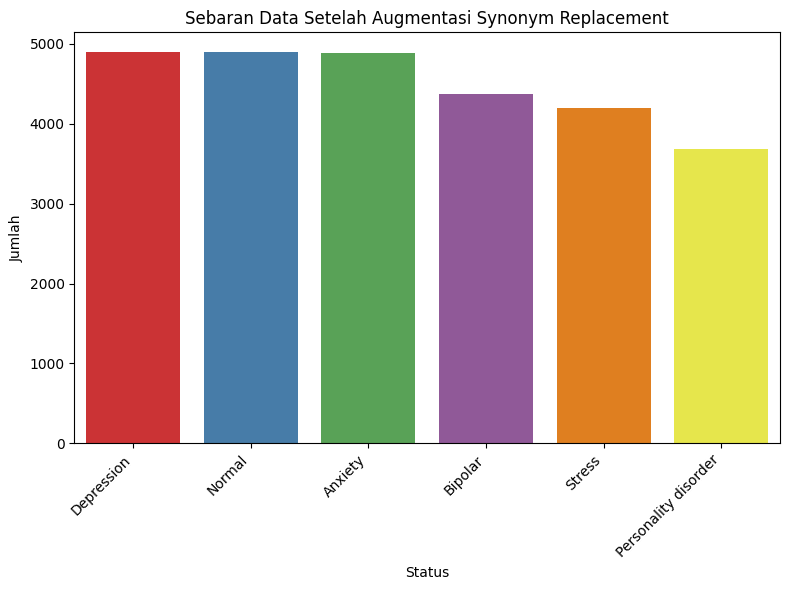

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Urutkan label berdasarkan jumlah dari terbesar ke terkecil
order = data['status'].value_counts().index

# Ukuran figure
plt.figure(figsize=(8, 6))

# Bar chart
sns.countplot(x='status', data=data, order=order, palette='Set1')

# Rotasi label sumbu x
plt.xticks(rotation=45, ha='right')

# Judul dan label sumbu
plt.title('Sebaran Data Setelah Augmentasi Synonym Replacement')
plt.xlabel('Status')
plt.ylabel('Jumlah')

# Biar rapi
plt.tight_layout()

# Tampilkan
plt.show()
